In [1]:
import sys
sys.path.append('/home/daniel/GMAT/R2020a/api/')
from load_gmat import *

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import cartopy.crs as ccrs

from astropy.time import Time

import pathlib

# Tianwen-1 clock epoch
epoch = np.datetime64('2015-12-31T16:00:00', 'us')

In [2]:
mars_fixed = gmat.Construct('CoordinateSystem', 'MarsFixed', 'Mars', 'BodyFixed')
mars_inertial = gmat.Construct('CoordinateSystem', 'MarsInertial', 'Mars', 'BodyInertial')

csConverter = gmat.CoordinateConverter()

tw1 = gmat.Construct('Spacecraft', 'Tianwen-1')

tw1.SetField('DateFormat', 'UTCModJulian')
tw1.SetField('CoordinateSystem', 'MarsInertial')
tw1.SetField('DisplayStateType', 'Cartesian')

fm = gmat.Construct('ForceModel', 'MarsFM')
fm.SetField('CentralBody', 'Mars')
grav = gmat.Construct('GravityField')
grav.SetField('BodyName', 'Mars')
grav.SetField('Degree', 8)
grav.SetField('Order', 8)
grav.SetField('PotentialFile', 'GMM2B.cof')
sungrav = gmat.Construct('PointMassForce')
sungrav.SetField('BodyName', 'Sun')
fm.AddForce(grav)
fm.AddForce(sungrav)

prop = gmat.Construct('Propagator', 'MarsProp')
pd78 = gmat.Construct('PrinceDormand78', 'MarsPD78')
prop.SetReference(pd78)
prop.SetReference(fm)
prop.AddPropObject(tw1)

gmat.Initialize()
prop.PrepareInternals()
pd78 = prop.GetPropagator()

rvIn  = gmat.Rvector6()
rvOut = gmat.Rvector6()

In [3]:
def open_tm(path, sel = slice(None)):
    with open(path) as f:
        tm_lines = f.readlines()[sel]
    tm_t = np.array([epoch + np.timedelta64(int(a.split()[0].lstrip('[').rstrip(']'), 16) * 100, 'us')
            for a in tm_lines])
    tm_x = np.array([[float(x) for x in a.split()[3:]] for a in tm_lines])
    return tm_t, tm_x

In [4]:
tm_folder = pathlib.Path('../tm_state_vectors/')

# The [2:] here is used to skip 20211107 and 20211108
tms = [open_tm(f) for f in
       list(sorted(tm_folder.glob('202111*'))[2:])
       + sorted(tm_folder.glob('202112*'))
       + sorted(tm_folder.glob('2022*'))
      ]
tm_t = np.concatenate([a[0] for a in tms])
tm_x = np.concatenate([a[1] for a in tms])

mjds = Time(tm_t).jd - 2430000.0

In [5]:
t_prop = []
x_prop = []
flag_sv = []

threshold = 60 / (3600 * 24)
prop_step = 32

for j in range(mjds.size - 1):
    t_prop.append(mjds[j])
    x_prop.append(tm_x[j])
    flag_sv.append(True)
    
    tw1.SetField('Epoch', str(mjds[j]))
    for a,c in zip(tm_x[j], ['X','Y','Z','VX','VY','VZ']):
        tw1.SetField(c, a)
    prop.PrepareInternals()
    
    while t_prop[-1] < mjds[j+1] - threshold:
        pd78.Step(prop_step)
        pd78.UpdateSpaceObject()
        t_prop.append(tw1.GetEpoch())
        x_prop.append(tw1.GetCartesianState().GetDataVector())
        flag_sv.append(False)
        
t_prop = np.array(t_prop)
x_prop = np.array(x_prop)
flag_sv = np.array(flag_sv)

In [6]:
x_prop_fixed = np.empty_like(x_prop)
mjd = gmat.A1Mjd()
for j in range(t_prop.size):
    t = mjd.UtcMjdToA1Mjd(t_prop[j])
    rvIn.Set(*x_prop[j])
    csConverter.Convert(t, rvIn, mars_inertial, rvOut, mars_fixed)
    x_prop_fixed[j] = rvOut.GetDataVector()

In [7]:
zhurong_long = 109.9
zhurong_lat = 25.1
r_mars = 3389.5
zhurong_fixed = r_mars * np.array([
    np.cos(np.deg2rad(zhurong_lat))*np.cos(np.deg2rad(zhurong_long)),
    np.cos(np.deg2rad(zhurong_lat))*np.sin(np.deg2rad(zhurong_long)),
    np.sin(np.deg2rad(zhurong_lat))])
zhurong_fixed_u = zhurong_fixed / np.sqrt(np.sum(zhurong_fixed**2))
v = x_prop_fixed[:, :3] - zhurong_fixed[np.newaxis, :]
v /= np.sqrt(np.sum(v**2, axis=1))[:, np.newaxis]
elevation = np.arccos(np.sum(v * zhurong_fixed_u, axis = 1))
zhurong_visible = np.rad2deg(elevation) < 90
zhurong_visible_30deg = np.rad2deg(elevation) < 90-30

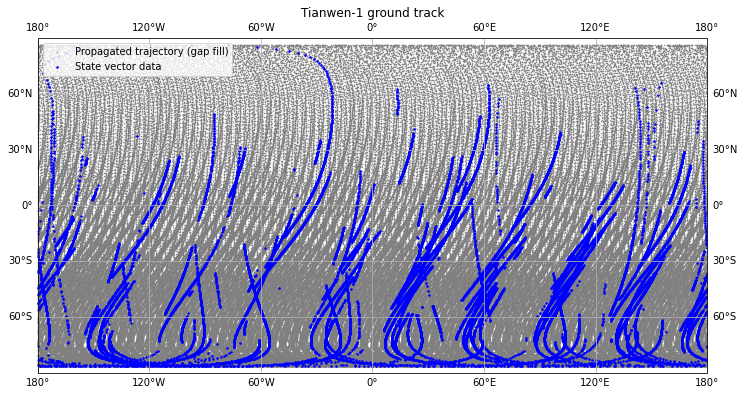

In [8]:
lon = np.rad2deg(np.arctan2(x_prop_fixed[:,1], x_prop_fixed[:,0]))
r = np.sqrt(np.sum(x_prop_fixed[:,:3]**2, axis = 1))
lat = np.rad2deg(np.arcsin(x_prop_fixed[:,2]/r))
equator = scipy.signal.argrelextrema(np.abs(lat), np.less)[0]
periapsis = scipy.signal.argrelextrema(r, np.less)[0]
periapsis = periapsis[r[periapsis] < 4000]
apoapsis = scipy.signal.argrelextrema(r, np.greater)[0]
apoapsis = apoapsis[r[apoapsis] > 13500]

time = Time(t_prop + 2430000.0, format = 'jd')

plt.figure(figsize = (12,12),  facecolor = 'w')
ax = plt.axes(projection=ccrs.PlateCarree())
ax.gridlines(draw_labels = True)
ax.plot(lon, lat, '.', markersize = 1,
        color = 'grey', label = 'Propagated trajectory (gap fill)',
        transform = ccrs.Geodetic())
ax.plot(lon[flag_sv], lat[flag_sv], '.',
        markersize = 3, color = 'blue', label = 'State vector data',
        transform = ccrs.Geodetic())
plt.legend()
plt.title('Tianwen-1 ground track')
plt.ylabel('Latitude (deg)')
plt.xlabel('Longitude (deg)');

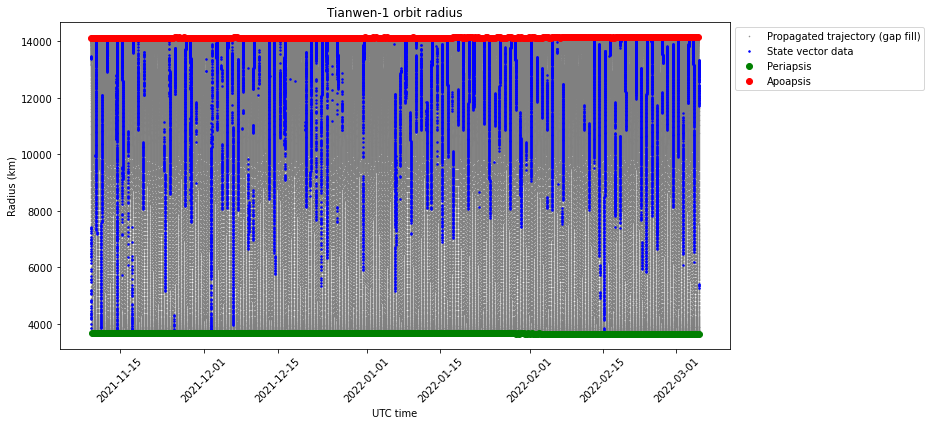

In [9]:
plt.figure(figsize = (12,6), facecolor = 'w')
plt.plot(time.datetime, r, '.', markersize = 1,
         color = 'grey', label = 'Propagated trajectory (gap fill)')
plt.plot(time[flag_sv].datetime, r[flag_sv], '.',
         markersize = 3, color = 'blue', label = 'State vector data')
plt.plot(time[periapsis].datetime, r[periapsis], 'o', color = 'green',
         label = 'Periapsis')
plt.plot(time[apoapsis].datetime, r[apoapsis], 'o', color = 'red',
         label = 'Apoapsis')
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')
plt.title('Tianwen-1 orbit radius')
plt.ylabel('Radius (km)')
plt.xlabel('UTC time')
plt.xticks(rotation=45);

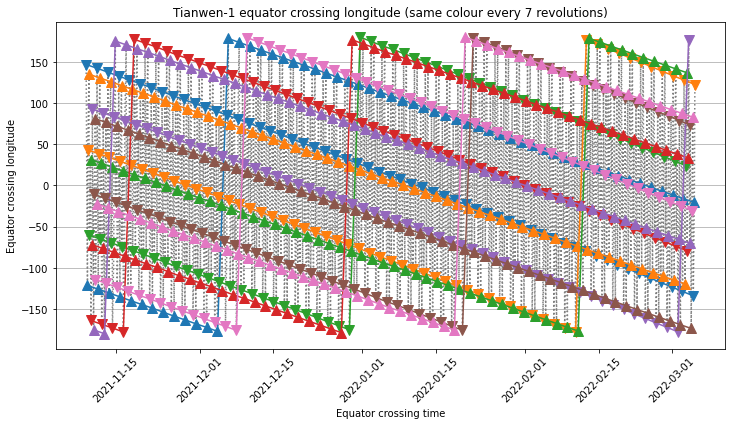

In [10]:
plt.figure(figsize = (12,6), facecolor = 'w')
plt.plot(Time(t_prop[equator] + 2430000.0, format = 'jd').datetime,
         lon[equator], ':', color='grey')
for j in range(14):
    color = j//2
    marker = 'v' if j % 2 == 0 else '^'
    plt.plot(Time(t_prop[equator][j::14] + 2430000.0, format = 'jd').datetime,
             lon[equator[j::14]], marker + '-', markersize=10, color=f'C{color}',
             label = 'Equator crossing longitude')
plt.title('Tianwen-1 equator crossing longitude (same colour every 7 revolutions)')
plt.ylabel('Equator crossing longitude')
plt.xlabel('Equator crossing time')
plt.grid(axis='y')
plt.xticks(rotation=45);

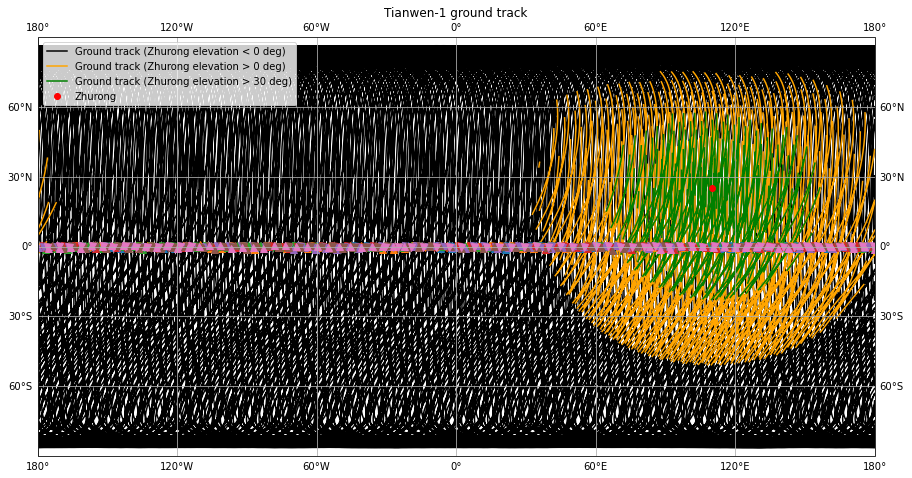

In [11]:
plt.figure(figsize = (15,15),  facecolor = 'w')
ax = plt.axes(projection=ccrs.PlateCarree())
ax.gridlines(draw_labels = True)
ax.plot(lon, lat, '-', color = 'black', label = 'Ground track (Zhurong elevation < 0 deg)',
        transform = ccrs.Geodetic())
lon_visible = lon.copy()
lat_visible = lat.copy()
lon_visible[~zhurong_visible] = np.nan
lat_visible[~zhurong_visible] = np.nan
ax.plot(lon_visible, lat_visible, '-', color = 'orange', label = 'Ground track (Zhurong elevation > 0 deg)',
        transform = ccrs.Geodetic())
lon_visible = lon.copy()
lat_visible = lat.copy()
lon_visible[~zhurong_visible_30deg] = np.nan
lat_visible[~zhurong_visible_30deg] = np.nan
ax.plot(lon_visible, lat_visible, '-', color = 'green', label = 'Ground track (Zhurong elevation > 30 deg)',
        transform = ccrs.Geodetic())
ax.plot([zhurong_long], [zhurong_lat], 'o', color='red', label='Zhurong',
        transform=ccrs.Geodetic())
for j in range(14):
    color = j//2
    ax.plot(lon[equator[j::14]], lat[equator[j::14]], 'v' if j % 2 == 0 else '^',
            markersize=7, color=f'C{color}',
            transform = ccrs.Geodetic())
plt.legend()
plt.ylabel('Latitude (deg)')
plt.xlabel('Longitude (deg)')
plt.title('Tianwen-1 ground track');

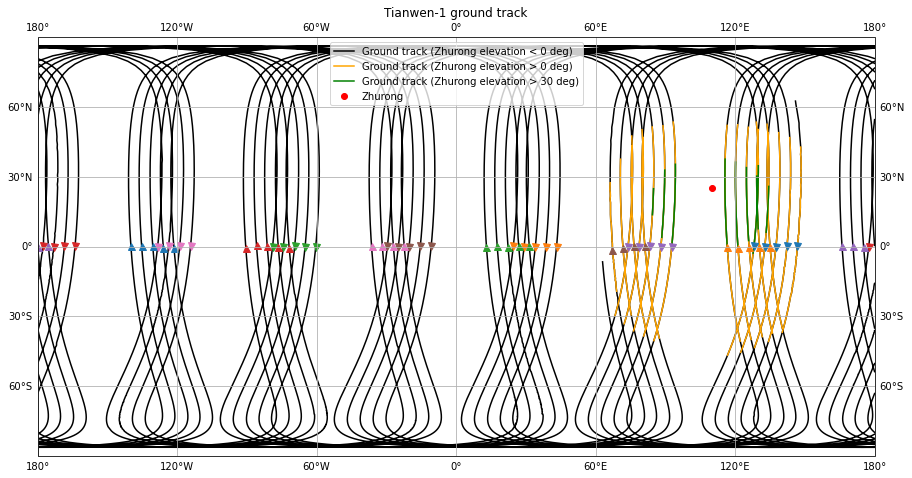

In [12]:
tsel = t_prop <= t_prop[0] + 10
equator_sel = t_prop[equator] <= t_prop[0] + 10
plt.figure(figsize = (15, 15),  facecolor = 'w')
ax = plt.axes(projection=ccrs.PlateCarree())
ax.gridlines(draw_labels = True)
ax.plot(lon[tsel], lat[tsel], '-', color = 'black', label = 'Ground track (Zhurong elevation < 0 deg)',
        transform = ccrs.Geodetic())
lon_visible = lon[tsel].copy()
lat_visible = lat[tsel].copy()
lon_visible[~zhurong_visible[tsel]] = np.nan
lat_visible[~zhurong_visible[tsel]] = np.nan
ax.plot(lon_visible, lat_visible, '-', color = 'orange', label = 'Ground track (Zhurong elevation > 0 deg)',
        transform = ccrs.Geodetic())
lon_visible = lon[tsel].copy()
lat_visible = lat[tsel].copy()
lon_visible[~zhurong_visible_30deg[tsel]] = np.nan
lat_visible[~zhurong_visible_30deg[tsel]] = np.nan
ax.plot(lon_visible, lat_visible, '-', color = 'green', label = 'Ground track (Zhurong elevation > 30 deg)',
        transform = ccrs.Geodetic())
ax.plot([zhurong_long], [zhurong_lat], 'o', color='red', label='Zhurong',
        transform=ccrs.Geodetic())
for j in range(14):
    color = j//2
    ax.plot(lon[equator[equator_sel][j::14]], lat[equator[equator_sel][j::14]], 'v' if j % 2 == 0 else '^',
            markersize=7, color=f'C{color}',
            transform = ccrs.Geodetic())
plt.legend()
plt.ylabel('Latitude (deg)')
plt.xlabel('Longitude (deg)')
plt.title('Tianwen-1 ground track');

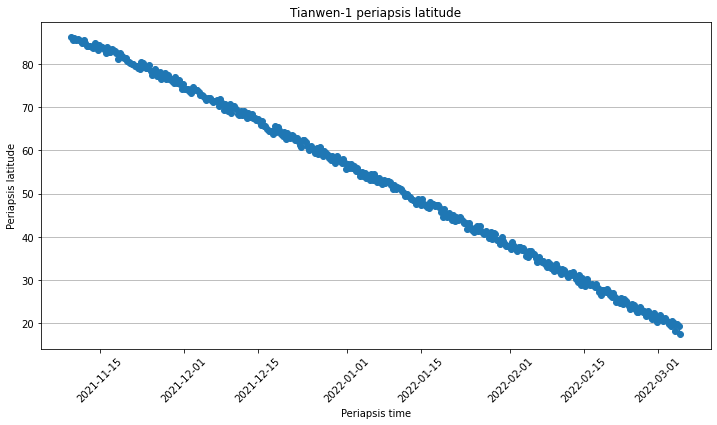

In [13]:
plt.figure(figsize = (12,6), facecolor = 'w')
plt.plot(Time(t_prop[periapsis] + 2430000.0, format = 'jd').datetime,
         lat[periapsis], 'o-', label = 'Periapsis latitude')
plt.title('Tianwen-1 periapsis latitude')
plt.ylabel('Periapsis latitude')
plt.xlabel('Periapsis time')
plt.grid(axis='y')
plt.xticks(rotation=45);

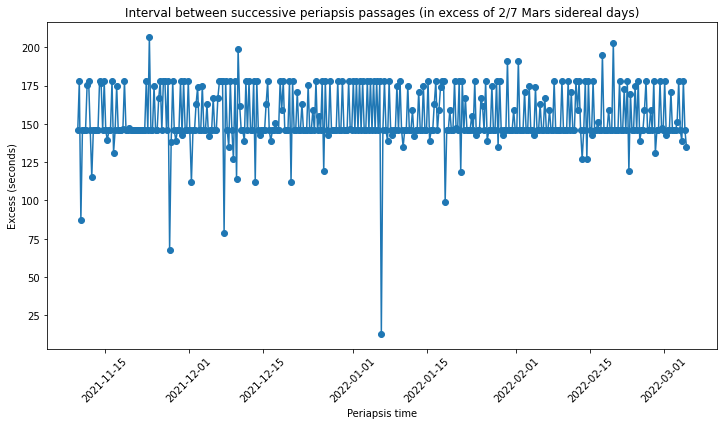

In [14]:
plt.figure(figsize = (12,6), facecolor = 'w')
passage_diff = np.diff(t_prop[periapsis]) * 24 * 3600 - 2/7 * (24 * 3600 + 37 * 60 + 22)
plt.plot(Time(t_prop[periapsis[1:]] + 2430000.0, format = 'jd').datetime,
        passage_diff, 'o-')
plt.title('Interval between successive periapsis passages (in excess of 2/7 Mars sidereal days)')
plt.ylabel('Excess (seconds)')
plt.xlabel('Periapsis time')
plt.xticks(rotation=45);

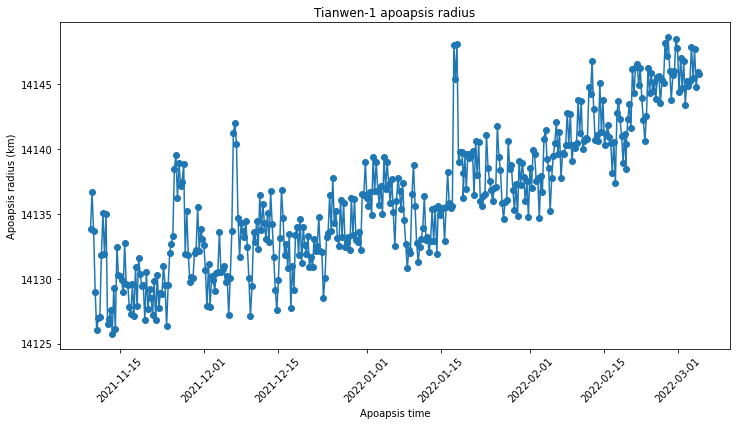

In [15]:
plt.figure(figsize = (12,6), facecolor = 'w')
plt.plot(Time(t_prop[apoapsis] + 2430000.0, format = 'jd').datetime,
         r[apoapsis], 'o-')
plt.title('Tianwen-1 apoapsis radius')
plt.xlabel('Apoapsis time')
plt.ylabel('Apoapsis radius (km)')
plt.xticks(rotation=45);

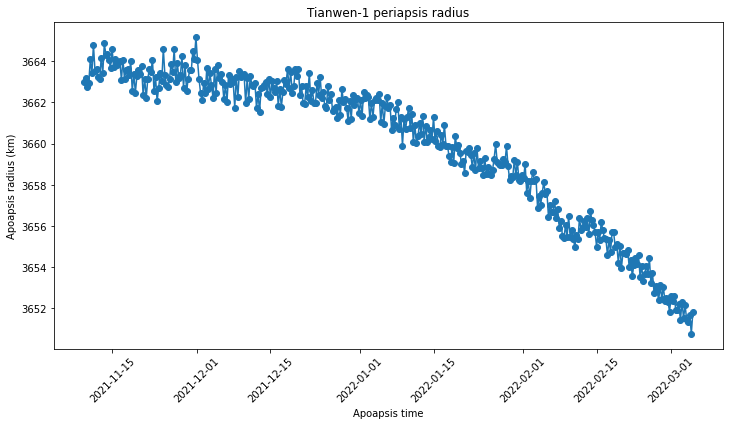

In [16]:
plt.figure(figsize = (12,6), facecolor = 'w')
plt.plot(Time(t_prop[periapsis] + 2430000.0, format = 'jd').datetime,
         r[periapsis], 'o-')
plt.title('Tianwen-1 periapsis radius')
plt.xlabel('Apoapsis time')
plt.ylabel('Apoapsis radius (km)')
plt.xticks(rotation=45);